In [31]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow 
from sklearn.model_selection import train_test_split

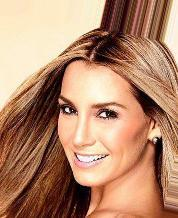

In [41]:
data_path = "C:\\Users\\Urszula"
image_path = "C:\\Users\\Urszula\\img_align_celeba"
image = cv2.imread("000001.jpg")
cv2_imshow(image)

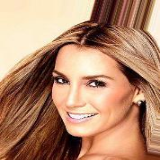

In [42]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(160, 160), 
    #albumentations.RandomCrop(300, 300),
    #albumentations.HorizontalFlip(), 
])
transformed_img = albumentations_transform(image=image)['image']
cv2_imshow(transformed_img)

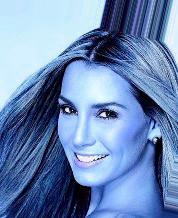

In [43]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2_imshow(image_rgb)

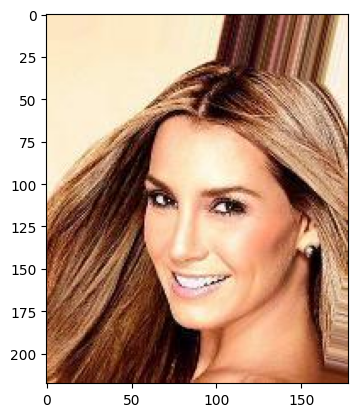

In [44]:
plt.imshow(image_rgb)

In [46]:
path2 = "list_attr_celeba.csv"
df = pd.read_csv(path2)
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [48]:
df.Male.replace((-1, 1), (0, 1), inplace=True)
df.Male.head()

0    0
1    0
2    1
3    0
4    0
Name: Male, dtype: int64

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy')

train_data, test_data = train_test_split(df, test_size=0.1)
train_data, val_data = train_test_split(train_data, test_size=0.1)

INPUT_RESOLUTION = (160, 160, 3)
BATCH_SIZE = 256
EPOCHS = 20

In [50]:
def my_data_generator_train():
    for index, row in train_data.iterrows():
        img = cv2.imread(os.path.join(image_path, row["image_id"]))
        resized_image = cv2.resize(img, INPUT_RESOLUTION[:2])/255
        yield resized_image, (row['Male'],)

def my_data_generator_test():
    for index, row in test_data.iterrows():
        img = cv2.imread(os.path.join(image_path, row["image_id"]))
        resized_image = cv2.resize(img, INPUT_RESOLUTION[:2])/255
        yield resized_image, (row['Male'],)

def my_data_generator_val():
    for index, row in val_data.iterrows():
        img = cv2.imread(os.path.join(image_path, row["image_id"]))
        resized_image = cv2.resize(img, INPUT_RESOLUTION[:2])/255
        yield resized_image, (row['Male'],)

In [52]:
train_ds = tf.data.Dataset.from_generator(my_data_generator_train, output_signature=(
    tf.TensorSpec(shape=INPUT_RESOLUTION, dtype=tf.float32),
    tf.TensorSpec(shape=(1,), dtype=tf.int8)))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)

val_ds = tf.data.Dataset.from_generator(my_data_generator_test, output_signature=(
    tf.TensorSpec(shape=INPUT_RESOLUTION, dtype=tf.float32),
    tf.TensorSpec(shape=(1,), dtype=tf.int8)))
val_ds = val_ds.batch(32)

test_ds = tf.data.Dataset.from_generator(my_data_generator_val, output_signature=(
    tf.TensorSpec(shape=INPUT_RESOLUTION, dtype=tf.float32),
    tf.TensorSpec(shape=(1,), dtype=tf.int8)))
test_ds = test_ds.batch(32)

In [53]:
base_model = tf.keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=INPUT_RESOLUTION
)

In [54]:
inputs = tf.keras.Input(shape=INPUT_RESOLUTION)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [56]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 convnext_tiny (Functional)  (None, 5, 5, 768)         27820128  
                                                                 
 global_average_pooling2d_1   (None, 768)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 769       
                                                                 
Total params: 27,820,897
Trainable params: 27,820,897
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping],
                    validation_data=val_ds,
                    use_multiprocessing=True)

Epoch 1/20


UnknownError: ignored

In [ ]:
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

In [ ]:
df = pd.DataFrame(history.history)
df.plot()